In [ ]:
!git clone https://github.com/mahmoudmhashem/ArSLr

Cloning into 'ArSLr'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 115 (delta 12), reused 44 (delta 10), pack-reused 62
Receiving objects: 100% (115/115), 90.27 MiB | 32.55 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 43.0 MB/s eta 0:00:00


In [ ]:
%cd 'ArSLr/alphabets/inference stage/'

/content/ArSLr/alphabets/inference stage


In [ ]:
import os
import cv2
import numpy as np
from MyModel import MyModel
# from PIL import Image

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# def putArText(image, text, color=(255, 0, 0), font_size=50, fontpath='../assets/amiri-regular.ttf'):
#     font = ImageFont.truetype(fontpath, font_size)
#     img_pil = Image.fromarray(image)
#     draw = ImageDraw.Draw(img_pil)
#     draw.text((50, 80),  text, font = font, fill = color)
#     img = np.array(img_pil)
#     return img

model = MyModel()

def putImage(frame, overlay_image, alpha = 255):
    base_image = PIL.Image.fromarray(frame)
    mask = PIL.Image.new('RGBA', overlay_image.size, (0, 0, 0, alpha))

    base_image.paste(overlay_image, mask=mask)
    frame = np.array(base_image)
    # frame = base_image
    return frame

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
label2text = {
 'aleff':'aleff - أ',
 'zay':'zay - ز',
 'seen':'seen - س',
 'sheen':'sheen - ش',
 'saad':'saad - ص',
 'dhad':'dhad - ض',
 'taa':'tah - ط',
 'dha':'dhaa - ظ',
 'ain':'ain - ع',
 'ghain':'ghain - غ',
 'fa':'faa - ف',
 'bb':'baa - ب',
 'gaaf':'qaaf - ق',
 'kaaf':'kaaf - ك',
 'laam':'laam - ل',
 'meem':'meem - م',
 'nun':'noon - ن',
 'ha':'haa - ه',
 'waw':'waw - و',
 'yaa':'ya - ئ',
 'toot':'taa marbouta - ة',
 'al':'al - لا',
 'ta':'taa - ت',
 'la':'la - ال',
 'ya':'yaa - ى',
 'thaa':'thaa - ث',
 'jeem':'jeem - ج',
 'haa':'haa - ح',
 'khaa':'khaa - خ',
 'dal':'dal - د',
 'thal':'thal - ذ',
 'ra':'raa - ر'
 }
labels = label2text.keys()
label2image = {}
for label in labels:
    imgname = label + '.png'
    imgpath = '../assets/image_lables/' + imgname
    label2image[label] = PIL.Image.open(imgpath)

In [ ]:


# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

  # JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Model:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

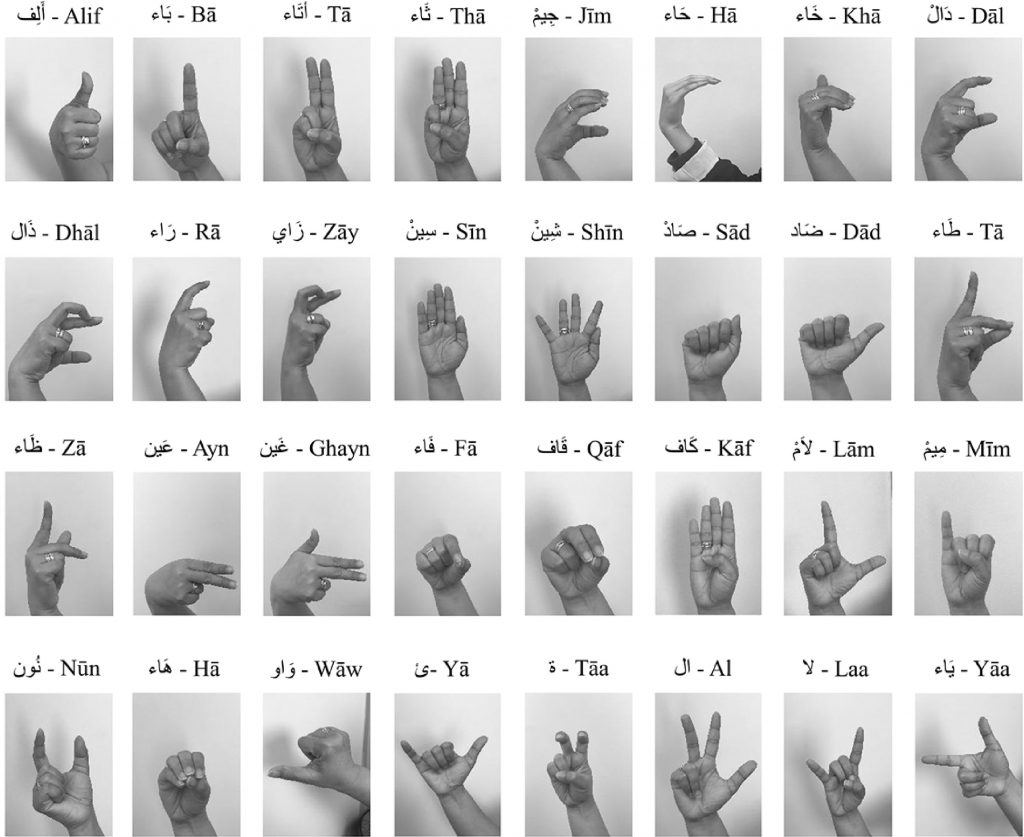

In [ ]:
video_stream()
overly = ''
label_html = 'Letters of Arabic Sign Language Recognition'
while True:
    js_reply = video_frame(label_html, overly)
    if not js_reply:
        break
    frame = js_to_image(js_reply["img"])

    label, prop = model.predict([frame])
    frame_overlay = np.zeros([480,640,4], dtype=np.uint8)

    if label[0] != '-1' and prop[0] > 0.6:
        image = label2image[label[0]]
        frame_overlay = putImage(frame_overlay, label2image[label[0]])
    else:
        cv2.putText(frame_overlay, "Please Sign a Letter", (150,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2, cv2.LINE_AA)
        frame_overlay[:,:,3] = (frame_overlay.max(axis = 2) > 0 ).astype(int) * 255



    overly = bbox_to_bytes(frame_overlay)

<IPython.core.display.Javascript object>